# AQI Prediction Pipeline (48-hour Forecast)

This notebook implements a robust pipeline for predicting AQI (ISPU) for the next 48 hours using XGBoost and recursive forecasting.

## Key Improvements:
- **Feature Engineering**: Manual lags and rolling statistics.
- **Regularization**: XGBoost parameters tuned to prevent overfitting.
- **Recursive Forecasting**: Iterative prediction for multi-step forecasting.
- **Pipeline**: Modular structure for easier deployment.

In [101]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set plot style
sns.set(style="whitegrid")

## 1. Feature Engineering Setup

In [102]:
# Lag and rolling window configuration without classes
lags = [1, 2, 3, 6, 12, 24]
rolls = [3, 6, 12, 24]

## 2. Load and Preprocess Data

In [103]:
raw = pd.read_csv("synthetic_iot_data.csv")

rename_map = {
    "Timestamp": "timestamp",
    "PM2.5 density": "pm25_density",
    "Air quality level": "air_quality_level"
}
if "PM2.5 density" in raw.columns:
    raw = raw.rename(columns=rename_map)

raw["timestamp"] = pd.to_datetime(raw["timestamp"])
raw = raw.sort_values("timestamp").set_index("timestamp")

In [104]:
raw

,No,PM2.5 raw,pm25_density,PM10 density,air_quality_level,Temperature,Humidity,Pressure,Altitude estimate,Device ID
timestamp,,,,,,,,,,
2025-12-05 22:00:00,1,31.9,46.0,70.2,BAIK,26.7,73.9,940.1,624.6,10:B4:1D:E8:2E:E4
2025-12-05 22:00:30,2,5.8,7.8,9.8,BAIK,27.7,72.1,940.7,624.4,10:B4:1D:E8:2E:E4
2025-12-05 22:01:00,3,38.4,55.2,83.4,SEDANG,26.9,69.3,940.8,625.1,10:B4:1D:E8:2E:E4
2025-12-05 22:01:30,4,5.4,7.8,11.8,BAIK,27.1,75.1,940.7,624.9,10:B4:1D:E8:2E:E4
2025-12-05 22:02:00,5,15.5,19.1,24.3,BAIK,26.5,74.2,940.6,623.8,10:B4:1D:E8:2E:E4
...,...,...,...,...,...,...,...,...,...,...
2026-01-09 15:17:30,99996,8.9,10.2,13.5,BAIK,22.8,91.5,940.5,624.2,10:B4:1D:E8:2E:E4
2026-01-09 15:18:00,99997,1.5,2.1,3.0,BAIK,22.6,88.4,940.5,624.8,10:B4:1D:E8:2E:E4
2026-01-09 15:18:30,99998,5.9,7.3,10.2,BAIK,22.9,89.6,940.9,624.0,10:B4:1D:E8:2E:E4


In [105]:
if "aqi_ispu" not in raw.columns:
    x_points = np.array([0.0, 15.5, 55.4, 150.4, 250.4, 500.0])
    y_points = np.array([0, 50, 100, 200, 300, 500])
    raw["aqi_ispu"] = np.interp(raw["pm25_density"], x_points, y_points)

# Keep ONLY pm25_density and aqi_ispu columns
df = raw[["pm25_density", "aqi_ispu"]].resample("1H").mean().ffill()

print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (834, 2)


C:\Users\user\AppData\Local\Temp\ipykernel_10256\1664491367.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = raw[["pm25_density", "aqi_ispu"]].resample("1H").mean().ffill()


,pm25_density,aqi_ispu
timestamp,,
2025-12-05 22:00:00,16.836667,39.689015
2025-12-05 23:00:00,14.455833,37.121699
2025-12-06 00:00:00,12.944167,35.858726
2025-12-06 01:00:00,12.380833,35.442699
2025-12-06 02:00:00,13.680833,36.541648


In [106]:
a = df.copy()
for l in lags:
    a[f"aqi_lag_{l}"] = a["aqi_ispu"].shift(l)
    a[f"pm25_lag_{l}"] = a["pm25_density"].shift(l)

for r in rolls:
    a[f"aqi_roll_mean_{r}"] = a["aqi_ispu"].rolling(r).mean()
    a[f"aqi_roll_std_{r}"] = a["aqi_ispu"].rolling(r).std()

In [107]:
a

,pm25_density,aqi_ispu,aqi_lag_1,pm25_lag_1,aqi_lag_2,pm25_lag_2,aqi_lag_3,pm25_lag_3,aqi_lag_6,pm25_lag_6,...,aqi_lag_24,pm25_lag_24,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_6,aqi_roll_std_6,aqi_roll_mean_12,aqi_roll_std_12,aqi_roll_mean_24,aqi_roll_std_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-05 22:00:00,16.836667,39.689015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05 23:00:00,14.455833,37.121699,39.689015,16.836667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 00:00:00,12.944167,35.858726,37.121699,14.455833,39.689015,16.836667,NaN,NaN,NaN,NaN,...,NaN,NaN,37.556480,1.951808,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 01:00:00,12.380833,35.442699,35.858726,12.944167,37.121699,14.455833,39.689015,16.836667,NaN,NaN,...,NaN,NaN,36.141041,0.874378,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 02:00:00,13.680833,36.541648,35.442699,12.380833,35.858726,12.944167,37.121699,14.455833,NaN,NaN,...,NaN,NaN,35.947691,0.554850,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 11:00:00,13.301667,35.429852,36.267437,12.840000,33.267014,12.188333,38.713076,15.148333,31.002079,11.054167,...,36.559270,13.579167,34.988101,1.548222,36.431911,1.918369,35.658510,2.477167,35.878116,2.048152
2026-01-09 12:00:00,13.873333,36.873544,35.429852,13.301667,36.267437,12.840000,33.267014,12.188333,37.303004,14.851667,...,36.836594,13.328333,36.190278,0.724933,36.360334,1.887125,35.856725,2.470755,35.879656,2.048918
2026-01-09 13:00:00,13.720833,36.375432,36.873544,13.873333,35.429852,13.301667,36.267437,12.840000,37.611081,14.156667,...,34.990246,12.645833,36.226276,0.733313,36.154392,1.788160,36.217393,2.160560,35.937372,2.042274


## 3. Training with Regularization

In [108]:
feature_df = df.copy()
feature_df["hour"] = feature_df.index.hour
feature_df["dayofweek"] = feature_df.index.dayofweek
feature_df["month"] = feature_df.index.month

for l in lags:
    feature_df[f"aqi_lag_{l}"] = feature_df["aqi_ispu"].shift(l)
    feature_df[f"pm25_lag_{l}"] = feature_df["pm25_density"].shift(l)

for r in rolls:
    feature_df[f"aqi_roll_mean_{r}"] = feature_df["aqi_ispu"].rolling(r).mean()
    feature_df[f"aqi_roll_std_{r}"] = feature_df["aqi_ispu"].rolling(r).std()

feature_df = feature_df.dropna()

features = [c for c in feature_df.columns if c not in ["aqi_ispu", "pm25_density"]]
target = feature_df["aqi_ispu"]

X = feature_df[features]
y = target

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

pipeline_data = {
    "model": model,
    "features": features,
    "lags": lags,
    "rolls": rolls
}
joblib.dump(pipeline_data, "aqi_pipeline.pkl")
print("Pipeline saved to 'aqi_pipeline.pkl'")

[0]	validation_0-rmse:2.06646	validation_1-rmse:1.97691


[100]	validation_0-rmse:0.25383	validation_1-rmse:0.78820
[200]	validation_0-rmse:0.10411	validation_1-rmse:0.72835
[200]	validation_0-rmse:0.10411	validation_1-rmse:0.72835
[300]	validation_0-rmse:0.05551	validation_1-rmse:0.71994
[300]	validation_0-rmse:0.05551	validation_1-rmse:0.71994
[400]	validation_0-rmse:0.03101	validation_1-rmse:0.71731
[400]	validation_0-rmse:0.03101	validation_1-rmse:0.71731
[500]	validation_0-rmse:0.01945	validation_1-rmse:0.71545
[500]	validation_0-rmse:0.01945	validation_1-rmse:0.71545
[600]	validation_0-rmse:0.01356	validation_1-rmse:0.71484
[600]	validation_0-rmse:0.01356	validation_1-rmse:0.71484
[700]	validation_0-rmse:0.01051	validation_1-rmse:0.71447
[700]	validation_0-rmse:0.01051	validation_1-rmse:0.71447
[800]	validation_0-rmse:0.00868	validation_1-rmse:0.71428
[800]	validation_0-rmse:0.00868	validation_1-rmse:0.71428
[900]	validation_0-rmse:0.00763	validation_1-rmse:0.71416
[900]	validation_0-rmse:0.00763	validation_1-rmse:0.71416
[999]	validati

In [109]:
feature_df

,pm25_density,aqi_ispu,hour,dayofweek,month,aqi_lag_1,pm25_lag_1,aqi_lag_2,pm25_lag_2,aqi_lag_3,...,aqi_lag_24,pm25_lag_24,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_6,aqi_roll_std_6,aqi_roll_mean_12,aqi_roll_std_12,aqi_roll_mean_24,aqi_roll_std_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-06 22:00:00,10.561667,30.132878,22,5,12,35.064737,12.916667,35.320545,12.915833,38.922856,...,39.689015,16.836667,33.506053,2.924054,34.896502,2.798363,35.427687,2.017456,35.543242,1.647288
2025-12-06 23:00:00,11.091667,31.465990,23,5,12,30.132878,10.561667,35.064737,12.916667,35.320545,...,37.121699,14.455833,32.221202,2.551189,34.333721,3.131114,34.989974,2.266375,35.307588,1.808333
2025-12-07 00:00:00,13.836667,37.132185,0,6,12,31.465990,11.091667,30.132878,10.561667,35.064737,...,35.858726,12.944167,32.910351,3.716478,34.673198,3.334044,35.025487,2.298816,35.360648,1.843548
2025-12-07 01:00:00,12.953333,34.835961,1,6,12,37.132185,13.836667,31.465990,11.091667,30.132878,...,35.442699,12.380833,34.478045,2.850003,33.992049,2.636755,34.919417,2.273513,35.335368,1.846531
2025-12-07 02:00:00,13.198333,36.050063,2,6,12,34.835961,12.953333,37.132185,13.836667,31.465990,...,36.541648,13.680833,36.006070,1.148744,34.113636,2.725590,34.987741,2.295910,35.314885,1.835261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 11:00:00,13.301667,35.429852,11,4,1,36.267437,12.840000,33.267014,12.188333,38.713076,...,36.559270,13.579167,34.988101,1.548222,36.431911,1.918369,35.658510,2.477167,35.878116,2.048152
2026-01-09 12:00:00,13.873333,36.873544,12,4,1,35.429852,13.301667,36.267437,12.840000,33.267014,...,36.836594,13.328333,36.190278,0.724933,36.360334,1.887125,35.856725,2.470755,35.879656,2.048918
2026-01-09 13:00:00,13.720833,36.375432,13,4,1,36.873544,13.873333,35.429852,13.301667,36.267437,...,34.990246,12.645833,36.226276,0.733313,36.154392,1.788160,36.217393,2.160560,35.937372,2.042274


In [110]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 648 entries, 2025-12-06 22:00:00 to 2026-01-02 21:00:00
Freq: h
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hour              648 non-null    int32  
 1   dayofweek         648 non-null    int32  
 2   month             648 non-null    int32  
 3   aqi_lag_1         648 non-null    float64
 4   pm25_lag_1        648 non-null    float64
 5   aqi_lag_2         648 non-null    float64
 6   pm25_lag_2        648 non-null    float64
 7   aqi_lag_3         648 non-null    float64
 8   pm25_lag_3        648 non-null    float64
 9   aqi_lag_6         648 non-null    float64
 10  pm25_lag_6        648 non-null    float64
 11  aqi_lag_12        648 non-null    float64
 12  pm25_lag_12       648 non-null    float64
 13  aqi_lag_24        648 non-null    float64
 14  pm25_lag_24       648 non-null    float64
 15  aqi_roll_mean_3   648 non-null    float64
 16 

In [111]:
X_train.columns.to_list()

['hour',
 'dayofweek',
 'month',
 'aqi_lag_1',
 'pm25_lag_1',
 'aqi_lag_2',
 'pm25_lag_2',
 'aqi_lag_3',
 'pm25_lag_3',
 'aqi_lag_6',
 'pm25_lag_6',
 'aqi_lag_12',
 'pm25_lag_12',
 'aqi_lag_24',
 'pm25_lag_24',
 'aqi_roll_mean_3',
 'aqi_roll_std_3',
 'aqi_roll_mean_6',
 'aqi_roll_std_6',
 'aqi_roll_mean_12',
 'aqi_roll_std_12',
 'aqi_roll_mean_24',
 'aqi_roll_std_24']

In [112]:
# evaluasi model untuk data training
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R2: {train_r2:.4f}")

Train RMSE: 0.0069
Train MAE: 0.0052
Train R2: 1.0000


## 4. Recursive Forecasting (48 Hours)

In [113]:
pipeline_data = joblib.load("aqi_pipeline.pkl")
model = pipeline_data["model"]
features = pipeline_data["features"]
lags = pipeline_data["lags"]
rolls = pipeline_data["rolls"]

historical_data = df.copy()
max_lookback = max(max(lags), max(rolls)) + 1
current_df = historical_data.tail(max_lookback).copy()

future_predictions = []
future_timestamps = []

last_timestamp = current_df.index[-1]
print(f"\nStarting 48h forecast from {last_timestamp}...")

for i in range(1, 49):
    next_time = last_timestamp + timedelta(hours=i)
    next_row = pd.DataFrame(index=[next_time], columns=current_df.columns)
    next_row["pm25_density"] = current_df["pm25_density"].iloc[-1]
    temp_df = pd.concat([current_df, next_row])

    df_feat = temp_df.copy()
    df_feat["hour"] = df_feat.index.hour
    df_feat["dayofweek"] = df_feat.index.dayofweek
    df_feat["month"] = df_feat.index.month

    for l in lags:
        df_feat[f"aqi_lag_{l}"] = df_feat["aqi_ispu"].shift(l)
        df_feat[f"pm25_lag_{l}"] = df_feat["pm25_density"].shift(l)

    for r in rolls:
        df_feat[f"aqi_roll_mean_{r}"] = df_feat["aqi_ispu"].rolling(r).mean()
        df_feat[f"aqi_roll_std_{r}"] = df_feat["aqi_ispu"].rolling(r).std()

    df_feat = df_feat.dropna()

    X_next = df_feat.iloc[[-1]][features]
    pred_aqi = model.predict(X_next)[0]

    future_predictions.append(pred_aqi)
    future_timestamps.append(next_time)

    temp_df.loc[next_time, "aqi_ispu"] = pred_aqi
    current_df = temp_df

forecast = pd.DataFrame({"timestamp": future_timestamps, "pred_aqi": future_predictions}).set_index("timestamp")
forecast.head()


Starting 48h forecast from 2026-01-09 15:00:00...



C:\Users\user\AppData\Local\Temp\ipykernel_10256\1349941521.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_df = pd.concat([current_df, next_row])
C:\Users\user\AppData\Local\Temp\ipykernel_10256\1349941521.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_df = pd.concat([current_df, next_row])
C:\Users\user\AppData\Local\Temp\ipykernel_10256\1349941521.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version,

,pred_aqi
timestamp,
2026-01-09 16:00:00,34.597923
2026-01-09 17:00:00,35.012321
2026-01-09 18:00:00,35.598515
2026-01-09 19:00:00,35.517197
2026-01-09 20:00:00,35.518196


## 5. Visualization

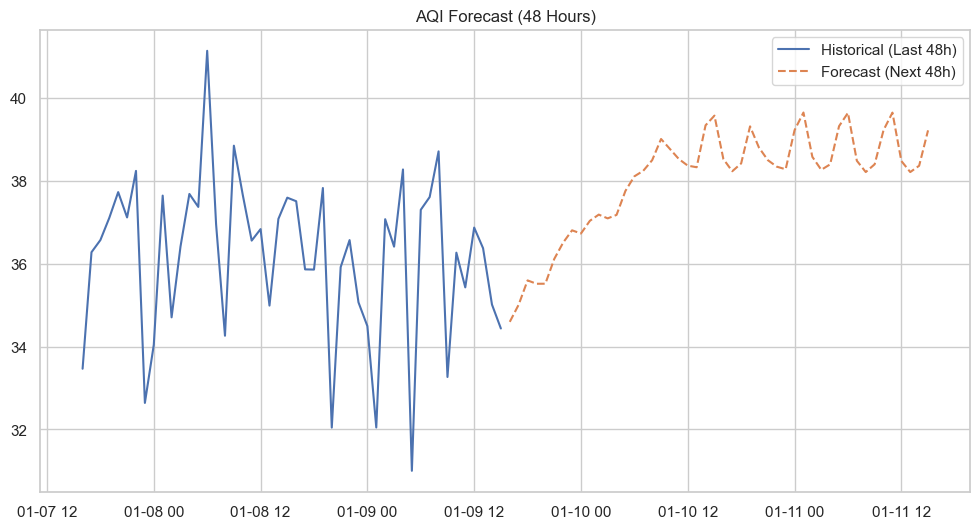

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-48:], df['aqi_ispu'].tail(48), label='Historical (Last 48h)')
plt.plot(forecast.index, forecast['pred_aqi'], label='Forecast (Next 48h)', linestyle='--')
plt.title("AQI Forecast (48 Hours)")
plt.legend()
plt.show()